In [12]:
allow_train = True
freeze_encoder = False
EPOCHS = 1
BATCH_SIZE = 128
load_pre_train_model = False

In [13]:
import os
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torchinfo import summary
from going_modular import engine, utils
from going_modular import custom_data_setup_main_train
import helper_functions
import shap

In [14]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [15]:
no_transforms = A.Compose([
    A.Resize(240, 240),       
    A.ToFloat(),
    ToTensorV2()
], seed=33)

p = 0.3

A_transforms = A.Compose([ 
    A.Resize(240, 240),
    # A.OpticalDistortion(distort_limit=0.3, p=p),
    # A.GridDistortion(num_steps=5, distort_limit=0.3, p=p),
    # A.ElasticTransform(alpha=40, sigma=50, p=p),
    # A.Affine(scale=[0.7, 1.4], translate_percent=[-0.05, 0.05], shear=[-15, 15], rotate=[-45, 45], p=p),
    # A.HorizontalFlip(p=p), 
    # A.VerticalFlip(p=p), 
    # A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=p),  
    # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=p),  
    # A.AdditiveNoise(noise_type='gaussian', spatial_mode='shared', approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.02, 0.05)}, p=p),
    # A.GaussianBlur(blur_limit=1, p=p),
    # A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=p),  
    # A.Emboss(alpha=(0.5, 0.6), strength=(0.6, 0.7), p=p),  
    # A.RandomGamma(gamma_limit=(80, 120), p=p),  
    # A.CoarseDropout(num_holes_range=(1, 2), hole_height_range=(0.1, 0.2), hole_width_range=(0.1, 0.2), fill=0, fill_mask=None, p=p),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToFloat(),
    ToTensorV2()
], seed=33)

In [16]:
test_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(transform=A_transforms,
                                                                                        batch_size=BATCH_SIZE)
exp_dataloader, class_names = custom_data_setup_main_train.create_test_dataloader(transform=no_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                                        batch_size=BATCH_SIZE) # set mini-batch size to 32

In [17]:
class ThreeHeadCNN(nn.Module):
    def __init__(self):
        super(ThreeHeadCNN, self).__init__()

        # Load EfficientNet encoder
        weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
        efficientNet = torchvision.models.efficientnet_b1(weights=weights)
        self.encoder = efficientNet.features

        # Pooling layers
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.batch_norm_1= nn.BatchNorm1d(1280) 
        self.batch_norm_2= nn.BatchNorm1d(1280)

        self.dense1 = nn.Linear(1280 * 2, 512)


        # Classification head
        self.classification_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 5) # 5 output nodes for classification
        )

        # Regression head
        self.regression_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 1) # 1 output node is for regression
        )

        # Ordinal regression head
        self.ordinal_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 5) # 5 output nodes for ordinal regression
        )

    def forward(self, x):
        x = self.encoder(x) # Extract features

        # Apply pooling layers
        max_pooled = self.global_max_pool(x).view(x.size(0), -1)
        avg_pooled = self.global_avg_pool(x).view(x.size(0), -1)

        # Concatenate
        x1 = self.batch_norm_1(max_pooled)
        x2 = self.batch_norm_2(avg_pooled)
        x = torch.concat([x1, x2], dim=1)
        x = torch.relu(self.dense1(x))

        # enc_out for visualizing data with t-SNE
        enc_out = x

        # Classification branch
        class_out = self.classification_head(x)

        # Regression branch
        reg_out = self.regression_head(x).squeeze(dim=1) # Single value

        # Ordinal regression branch
        ord_out = self.ordinal_head(x)

        return class_out

    
model = ThreeHeadCNN().to(device)

In [18]:
# Get a batch of data from the DataLoader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)  # images: (batch_size, C, H, W)

# Select background and test samples
background = images[:100]  # shape: (100, C, H, W)
test_images = images[100:105]  # shape: (5, C, H, W)


In [19]:
test_images.shape

torch.Size([5, 3, 240, 240])

In [ ]:
explainer = shap.GradientExplainer(model, background)

In [21]:
shap_values = explainer.shap_values(test_images)
shap_values

array([[[[[ 4.73433691e-07,  2.19444684e-07,  3.14183080e-07,
            2.01836650e-07,  1.37076256e-08],
          [ 9.78056707e-08, -6.04914446e-08, -5.29017379e-08,
            1.77586487e-07, -5.04672057e-08],
          [-1.62278187e-08, -3.61124829e-08, -9.42544438e-08,
            2.49680267e-07, -6.23921118e-08],
          ...,
          [-6.28425811e-06, -9.05211396e-06, -3.13797056e-06,
           -1.14755899e-05,  1.76058713e-06],
          [ 2.93553591e-07, -4.81130561e-07, -3.51900250e-07,
           -1.57775729e-06,  1.22635335e-06],
          [ 1.64012558e-07,  2.47097875e-08, -2.07726200e-08,
           -9.70758357e-08, -2.81956263e-08]],

         [[ 1.92659163e-07,  1.33415523e-07,  1.51563738e-07,
            1.07182333e-07, -1.25550224e-07],
          [ 4.81431383e-07,  1.22593021e-07,  2.28176574e-07,
            2.99099398e-07, -1.45285984e-07],
          [ 1.61277539e-07, -1.75842692e-08, -2.84913743e-08,
            4.71679895e-07, -2.00788075e-07],
          .

In [22]:
shap_values.shape

(5, 3, 240, 240, 5)

In [23]:
# Convert to NumPy and transpose from (N, C, H, W) to (N, H, W, C)
test_images_np = test_images.detach().cpu().numpy().transpose(0, 2, 3, 1)

IndexError: index 3 is out of bounds for axis 0 with size 3

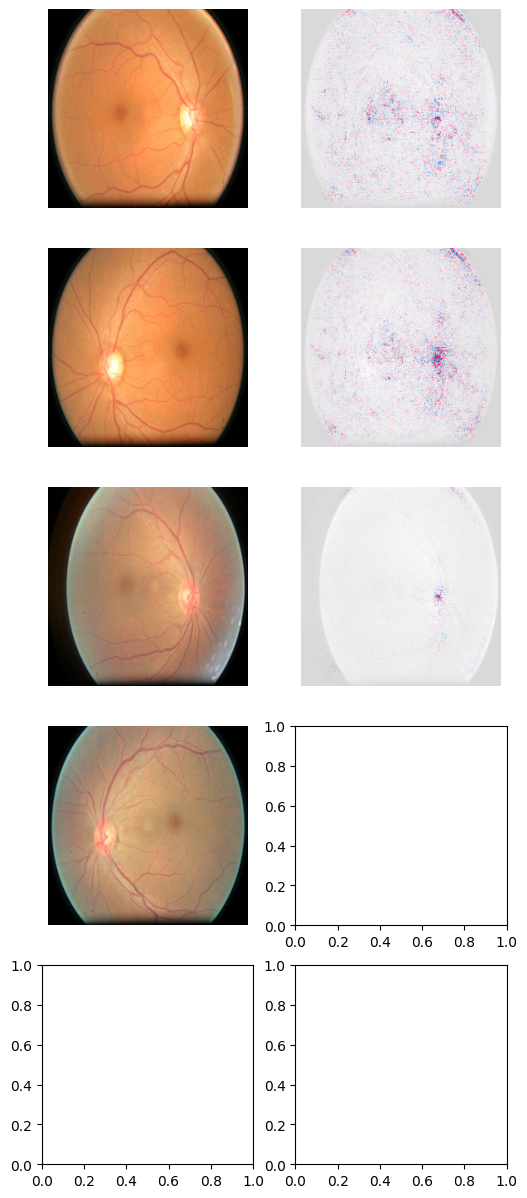

In [24]:
import shap

# Plot for class 0
shap.image_plot(shap_values[0], test_images_np)
